<a href="https://colab.research.google.com/github/tbeucler/2024_TROPICANA_ML/blob/main/ENSO_TCs_Seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from keras.layers import Dense, Activation
import keras
keras.utils.set_random_seed(812)

In [2]:
def open_oni_dataset(year_start=1955, year_end=2023, season='JJA'):
  """
  Open and preprocess NOAA ONI dataset.
  Returns ONI for the year range and season selected.
  """
  # reading dataset from NOAA online
  enso_dataset = pd.read_csv(
      'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
      delim_whitespace=True
      )
  # filter by year range
  enso_dataset = enso_dataset[
      (enso_dataset['YR']>=year_start)&(enso_dataset['YR']<=year_end)
      ]
  # filter by season
  enso_dataset = enso_dataset[enso_dataset['SEAS']==season]
  # return anomalies/ONI as numpy array
  return np.asarray(enso_dataset["ANOM"])

In [3]:
def open_tc_dataset(year_start=1955, year_end=2023, mo_start=8, mo_end=10, rolling_yrs=30):
  """
  Open and preprocess ibtracs dataset.
  Returns integer encoded classes for negative/positive anomalies of TC frequency for period selected.
  """
  # reading dataset from NOAA online
  tc_dataset = pd.read_csv(
    'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/csv/ibtracs.NA.list.v04r01.csv',
    skiprows = [1]
    )
  # dummy arrays for masking
  year_tmp = pd.to_datetime(
      tc_dataset['ISO_TIME'].array
      ).year
  mo_tmp = pd.to_datetime(
      tc_dataset['ISO_TIME'].array
      ).month
  # filter using year range
  tc_dataset = tc_dataset[
      (year_tmp>=year_start)&(year_tmp<=year_end)&(mo_tmp>=mo_start)&(mo_tmp<=mo_end)
      ]
  # only consider tropical cyclones
  tc_dataset = tc_dataset[
      tc_dataset['NATURE']=='TS'
      ]
  # add year column
  tc_dataset['YR'] = pd.to_datetime(
      tc_dataset['ISO_TIME'].array
      ).year
  # count unique tcs per year
  tc_dataset = tc_dataset.groupby('YR')['NAME'].nunique()
  # rolling climatology
  climo = tc_dataset.rolling(rolling_yrs, min_periods=1, center=True).mean()
  # anomalies from climo
  tc_anom = tc_dataset - climo
  # create two classes; 0 when negative anom, 1 when positive anom
  integer_encoding = np.where(tc_anom < 0, 0, 1)
  return integer_encoding

In [4]:
yr0 = 1955
yr1 = 2023

enso_ds = open_oni_dataset(
    year_start=yr0, year_end=yr1, season='JJA'
    )
tc_ds = open_tc_dataset(
    year_start=yr0, year_end=yr1, mo_start=8, mo_end=10, rolling_yrs=30
    )

<ipython-input-3-61c4ef95ad48>:7: DtypeWarning: Columns (3,19,20,23,24,40,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  tc_dataset = pd.read_csv(


In [5]:
enso_ds

array([-0.68, -0.57,  1.25,  0.57, -0.18,  0.13,  0.14, -0.04,  0.86,
       -0.6 ,  1.22,  0.24,  0.05,  0.58,  0.36, -0.63, -0.8 ,  1.13,
       -1.11, -0.53, -1.13,  0.18,  0.35, -0.36,  0.04,  0.25, -0.3 ,
        0.79,  0.31, -0.3 , -0.49,  0.22,  1.51, -1.3 , -0.31,  0.33,
        0.73,  0.37,  0.32,  0.44, -0.24, -0.27,  1.6 , -0.78, -1.1 ,
       -0.55, -0.08,  0.79,  0.08,  0.47, -0.06,  0.1 , -0.56, -0.37,
        0.45, -1.05, -0.48,  0.25, -0.4 ,  0.05,  1.52, -0.36,  0.14,
        0.09,  0.28, -0.41, -0.4 , -0.81,  1.07])

In [6]:
tc_ds

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1])

In [7]:
# in the case that you'd like minmax scaling (to rescale features):

# Feature Scaling
# sc = MinMaxScaler(feature_range=(0,1))

# do rescaling
# enso_scaled = sc.fit_transform(enso_ds.reshape(-1, 1))

In [8]:
# metrics that are useful for classification, particularly for two classes
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [9]:
num_folds = 5
BATCH_SIZE = 32
EPOCHS = 100

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(enso_ds, tc_ds):

  # Define the model architecture
  model = keras.Sequential() # instantiate model object

  # Creating our input layer (not required, but I recommend this because
  # it lets the model get built continuously as you are adding layers rather than waiting till the end to build).
  model.add(keras.Input(shape=(1,), name="input_layer"))

  # Now lets add our hidden layers
  model.add(
      keras.layers.Dense(units=4, activation=keras.activations.relu)
      )
  model.add(
      keras.layers.Dense(units=4, activation=keras.activations.relu)
      )

  # Finally, we add last fully connected (dense) layers
  model.add(keras.layers.Dense(1, activation="sigmoid"))

  # print model summary
  model.summary()

  # Compile the model
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      loss='mse',
      metrics=METRICS
  )

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(
    x=enso_ds[train],
    y=tc_ds[train],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0
  )

  # Generate generalization metrics
  scores = model.evaluate(enso_ds[test], tc_ds[test], verbose=0)

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 8         
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.21612970530986786; accuracy of 64.28571343421936%
Model: "sequential_1"
_________________________________________________________________
 Layer (type)        

Score for fold 5: loss of 0.23449820280075073; accuracy of 76.92307829856873%


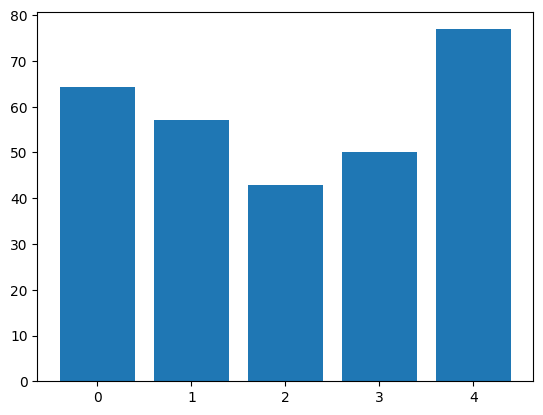

In [23]:
plt.bar(range(0, num_folds), acc_per_fold)
plt.show()

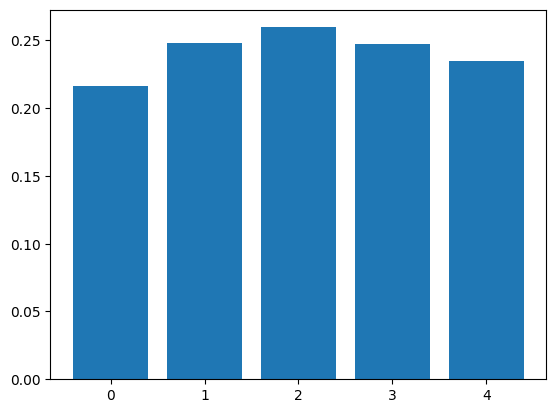

In [22]:
plt.bar(range(0, num_folds), loss_per_fold)
plt.show()

## Tutorial Practice: How do metrics vary based on the number of k-folds?

In [11]:
# recreate the model/kfold experiment and training

In [14]:
# evaluate the new model's skill

Other sample questions for practice:

- How does batch size impact model training?

- How does the learning rate impact model training?

- Does data augmentation help with model skill?

- Does reducing regularization impact overfitting (hint: add dropout or batchnorm)?

## What about categorical prediction with one-hot encoding?

In [24]:
# convert labels into classes using one-hot encoding
onehot_layer = keras.layers.CategoryEncoding(num_tokens=2, output_mode="one_hot")
tc_onehot = onehot_layer(tc_ds.astype(int))

In [47]:
tc_ds[:5]

array([1, 0, 0, 1, 0])

In [48]:
tc_onehot[:5,:]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)>

In [49]:
num_folds = 5
BATCH_SIZE = 32
EPOCHS = 100

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(enso_ds, tc_onehot):

  # Define the model architecture
  model = keras.Sequential() # instantiate model object

  # Creating our input layer (not required, but I recommend this because
  # it lets the model get built continuously as you are adding layers rather than waiting till the end to build).
  model.add(keras.Input(shape=(1,), name="input_layer"))

  # Now lets add our hidden layers
  model.add(
      keras.layers.Dense(units=4, activation=keras.activations.relu)
      )
  model.add(
      keras.layers.Dense(units=4, activation=keras.activations.relu)
      )

  # Finally, we add last fully connected (dense) layers
  model.add(keras.layers.Dense(2, activation="softmax"))

  # print model summary
  model.summary()

  # Compile the model
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      loss=keras.losses.BinaryCrossentropy(), # categorical loss function
      metrics=METRICS
  )

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(
    x=enso_ds[train],
    y=tc_onehot.numpy()[train],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0
  )

  # Generate generalization metrics
  scores = model.evaluate(enso_ds[test], tc_onehot.numpy()[test], verbose=0)

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 4)                 8         
                                                                 
 dense_25 (Dense)            (None, 4)                 20        
                                                                 
 dense_26 (Dense)            (None, 2)                 10        
                                                                 
Total params: 38 (152.00 Byte)
Trainable params: 38 (152.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 1 ...


Score for fold 1: loss of 0.6559794545173645; accuracy of 78.57142686843872%
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 4)                 8         
                                                                 
 dense_28 (Dense)            (None, 4)                 20        
                                                                 
 dense_29 (Dense)            (None, 2)                 10        
                                                                 
Total params: 38 (152.00 Byte)
Trainable params: 38 (152.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.7159538269042969; accuracy of 35.71428656578064%
Model: "sequential_10"
________

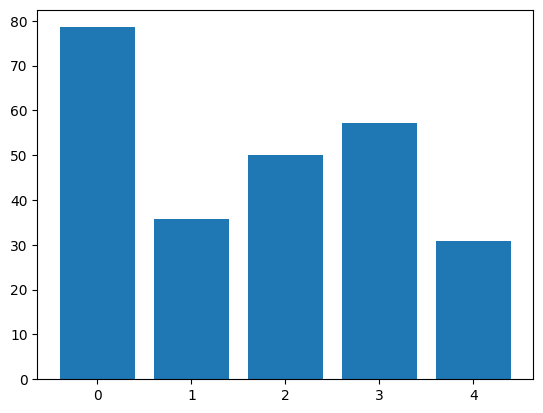

In [53]:
plt.bar(range(0, num_folds), acc_per_fold)
plt.show()

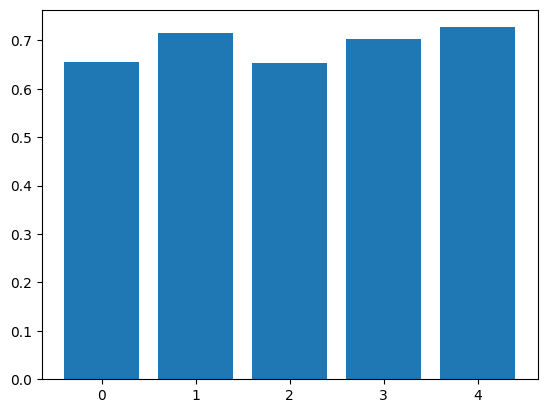

In [52]:
plt.bar(range(0, num_folds), loss_per_fold)
plt.show()